In [2]:
!pip install tensorly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 56.3 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
import tensorly as tl
from tensorly.decomposition import parafac
import matplotlib.pyplot as plt


In [4]:
def split_matrix(X, block_size):
    I, J = X.shape
    blocks = []

    for i in range(0, I, block_size):
        for j in range(0, J, block_size):
            sub_matrix = X[i:i+block_size, j:j+block_size]
            blocks.append((i, j, sub_matrix))

    return blocks

In [23]:
def compress_matrix_tensor(X, rank=10):
    # Convertir le tensor PyTorch en tensor Tensorly avec tl.tensor
    tl_tensor = tl.tensor(X.numpy())  # Utiliser tl.tensor pour la conversion
    factors = parafac(tl_tensor, rank=rank)
    # Reconstruction à partir des facteurs de la décomposition CP
    compressed_tensor = tl.cp_to_tensor(factors)  # Utiliser tl.cp_to_tensor ici
    return torch.from_numpy(compressed_tensor)

In [14]:
class OpenTensorNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(OpenTensorNN, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [15]:
def train_model(model, dataloader, epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_history = []

    for epoch in range(epochs):
        epoch_loss = 0

        for inputs, targets in dataloader:
            inputs = inputs.view(inputs.shape[0], -1)
            targets = targets.view(targets.shape[0], -1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        loss_history.append(avg_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    # Visualisation de la courbe de perte
    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), loss_history, label="Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Évolution de la Perte du Modèle")
    plt.legend()
    plt.grid()
    plt.show()


In [16]:
# Visualiser les résultats
def visualize_results(model, dataloader):
    model.eval()

    inputs, targets = next(iter(dataloader))
    inputs = inputs.view(inputs.shape[0], -1)
    targets = targets.view(targets.shape[0], -1)

    outputs = model(inputs).detach()

    idx = 0
    original = targets[idx].view(500, 500).cpu().numpy()
    reconstructed = outputs[idx].view(500, 500).cpu().numpy()

    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(original, cmap="viridis")
    ax[0].set_title("Matrice Originale")

    ax[1].imshow(reconstructed, cmap="viridis")
    ax[1].set_title("Matrice Reconstituée")

    plt.show()

Epoch [1/10], Loss: 15.0603
Epoch [2/10], Loss: 0.2551
Epoch [3/10], Loss: 0.2534
Epoch [4/10], Loss: 0.2514
Epoch [5/10], Loss: 0.2492
Epoch [6/10], Loss: 0.2467
Epoch [7/10], Loss: 0.2441
Epoch [8/10], Loss: 0.2413
Epoch [9/10], Loss: 0.2385
Epoch [10/10], Loss: 0.2355


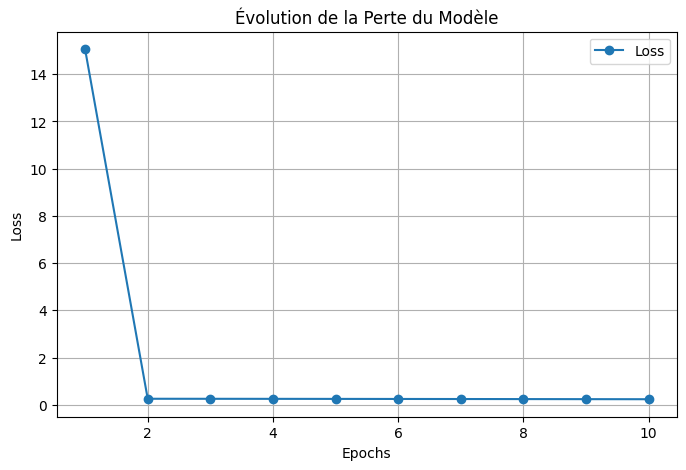

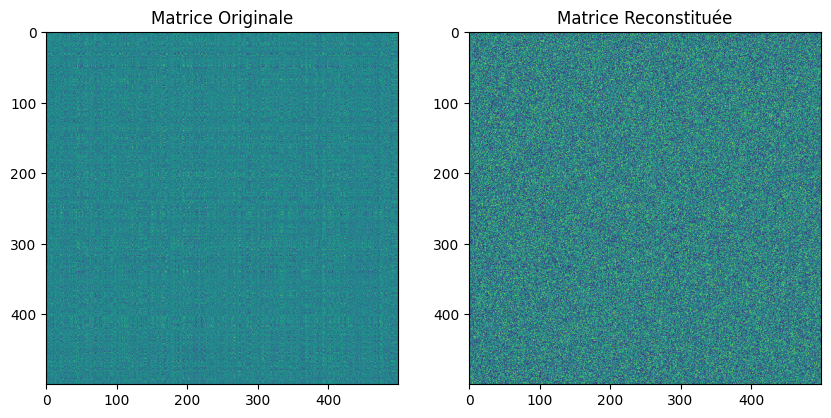

In [24]:
X_large = torch.rand(5000, 5000)

block_size = 500
blocks = split_matrix(X_large, block_size)

# Compression des blocs avec une décomposition tensorielle CP
compressed_blocks = [(i, j, compress_matrix_tensor(block)) for i, j, block in blocks]

# Définir les dimensions d'entrée
input_dim = block_size ** 2
hidden_dim, output_dim = 256, input_dim

model = OpenTensorNN(input_dim, hidden_dim, output_dim)

# Préparation des données pour le DataLoader
dataset = [(block.flatten(), block.flatten()) for _, _, block in compressed_blocks]
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Entraînement et visualisation
train_model(model, dataloader)
visualize_results(model, dataloader)